In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the cleaned audio features file as a pandas dataframe

audio_features = pd.read_csv('audio_features.csv', index_col='track_id')
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [3]:
# scale tempo using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

audio_features.tempo = MinMaxScaler().fit_transform(audio_features.tempo.values.reshape(-1,1))
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072


Now I implement the GMM algorithm, using the EM method.

In [4]:
# implement Gaussian Mixture Model

# initialize means, covariances, and mixing coefficients

def initialize(X, k):
    n, m = X.shape
    
    # use K-means to initialize the means
    kmeans = KMeans().fit(X)
    mu = kmeans.cluster_centers_
    sigma = np.array([np.eye(m)] * k)
    pi = np.ones(k)/k
    return mu, sigma, pi

# implement expectation-maximization algorithm

# compute responsibilities using initialized parameters
def e_step(mu, sigma, pi, k):
    n, m = X.shape
    gamma = np.zeros((k, n))
    
    for j in range(k):
        for i in range(n):
            gamma[j, i] = multivariate_normal(mu[j], sigma[j]).pdf(X[i]) * pi[j]
            
    gamma = gamma/gamma.sum(axis=0)
    return gamma

# re-estimate parameter values using responsibilities computed in e-step
def m_step(gamma, k):
    n, m = X.shape
    mu = np.zeros((k, m))
    sigma = np.zeros((k, m, m))
    pi = np.zeros(k)
    
    for j in range(k):
        
        for i in range(m):
            mu[j] += gamma[j, i] * X[i]
            
        mu[j] = mu[j]/gamma[j, :].sum()    
    
        for i in range(n):
            ys = np.reshape(X[i]- mu[j], (m, 1))
            sigma[j] += gamma[j, i] * np.dot(ys, ys.T)
            pi[j] += gamma[j, i]
            
        sigma[j] = sigma[j]/gamma[j,:].sum()
        
    pi = pi/n
        
    return mu, sigma, pi

def my_gmm(X, k, max_iter, threshold):
    n, m = X.shape
    mu, sigma, pi = initialize(X, k)
    
    old_logl = 0
    
    # loop through iterations
    for i in range(max_iter):
        
        # apply EM algorithm
        gamma = e_step(mu, sigma, pi, k)
        mu, sigma, pi = m_step(gamma, k)
        
        new_logl = 0
        
        # compute log likelihoods
        for i in range(n):
            temp = 0
            for j in range(k):
                temp += pi[j] * multivariate_normal(mu[j], sigma[j]).pdf(X[i])
            new_logl += np.log(temp)
            
        # stopping criterion for log likelihood convergence
        if np.abs(new_logl - old_logl) < threshold:
            break
            
        old_logl = new_logl
        
    return mu, sigma, pi, gamma

# partial source: https://github.com/Monisha-Balaji/Data-Mining-Clustering-Algorithms/blob/master/project2_Clustering/Codes/GMM.py
# full reference in bibliography

In [5]:
# apply PCA on dataset to reduce the number of dimensions to 2 for visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(audio_features)

In [6]:
# calculate BIC for a range of k to determine the optimal k

from sklearn.mixture import GaussianMixture
from sklearn import metrics

lowest_bic = np.infty
bic = []
n_components_range = range(2, 7)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

# source: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
# full reference in bibliography

In [7]:
best_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

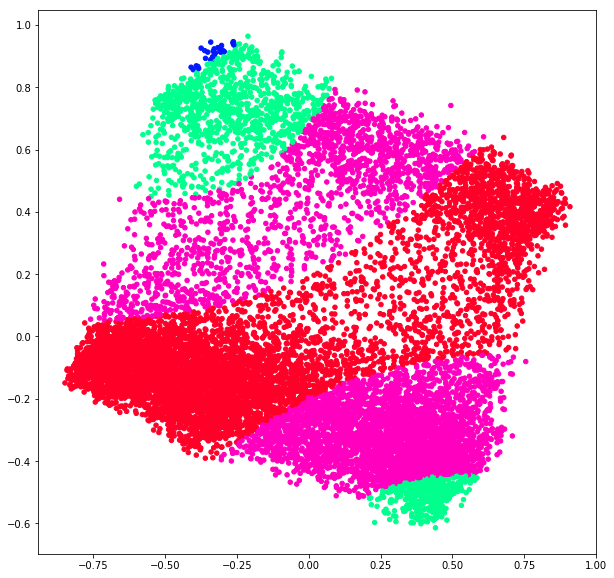

In [8]:
# apply gmm algorithm on dataset and visualize the clusters formed
# note: takes quite some time to run - perhaps an hour on my machine

mu, sigma, pi, gamma = my_gmm(X, 6, 100, 0.001)
labels = gamma.argmax(axis=0)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], s=20, c=labels, cmap='gist_rainbow')
plt.show()

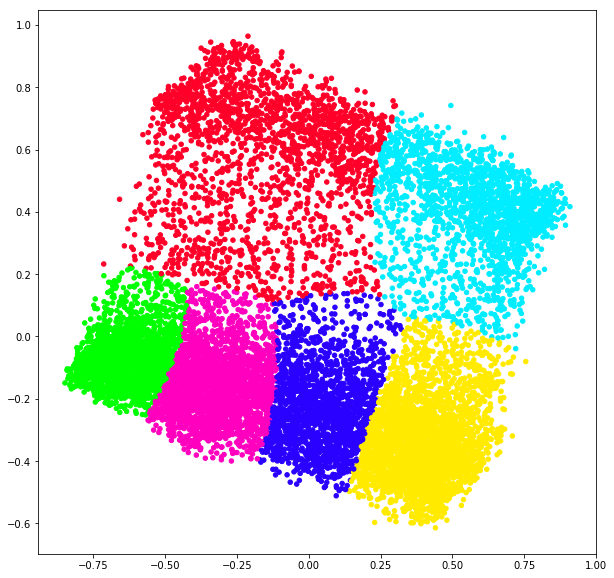

In [9]:
# compare with scikit-learn algorithm

gmm = GaussianMixture(n_components=6, random_state=1).fit(X)
pca_labels = gmm.predict(X)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=pca_labels, cmap='gist_rainbow')
plt.show()

In [10]:
# evaluate clustering results using scikit-learn metrics module

from sklearn import metrics

metrics.silhouette_score(X, labels, metric='euclidean')

0.0933978776586403

In [11]:
# add cluster labels to dataframe

tracks = audio_features.copy()
tracks['gmm_label'] = labels
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,gmm_label
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,4
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,4
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,0
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,0
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,4


In [12]:
# take a look at cluster sizes

tracks.groupby('gmm_label').size()

gmm_label
0    6360
2    1357
3      30
4    5382
dtype: int64

No points have been assigned to cluster label 1, and majority of the points are grouped into clusters 0 and 4.